In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
#sys.path.append(os.path.abspath(
# FROM DOTENV IMPORTos.path.join(os.getcwd(), '..')))
from app.helpers import *
from app.cycling_physics import *
from dotenv import load_dotenv
import os
load_dotenv()
route_path = os.getenv('ROUTE_PATH')

In [23]:
from app.cycling_physics import *
n = 10
routes = os.listdir(route_path)
route = routes[4]
print(route)
route = os.path.join(route_path,route)
df_raw = pd.read_csv(route)
df = df_raw.copy()
display(df.head())
#Create a function segment_course that takes in a dataframe and n and returns a dataframe with n segments
def simple_course_segment(df, n):
    #Create a new column called segment that segments the course into n equal parts
    df['segment'] = pd.cut(df['distance'], n, labels=False)
    return df


#segment the course into n=10 equal parts and groupby average the course segments
n = 10
df = simple_course_segment(df, n)
#display(df)
#df.fillna(0, inplace=True)
#only gropuby aggregate the numerical columns

df = df.groupby('segment').agg({'lat':'mean','lon':'mean','altitude':'min','gradient':'mean', 'altitude':'mean', 'distance':'sum'})
df = df.reset_index()
df = df.dropna()
df['gradient'] = df['gradient']/100
df['wind'] = 0
#df = df.drop(columns=['segment'])
course_segments = df[['altitude','distance','gradient', 'altitude']]
course_segments['wind'] = 0
course_segments['gradient'] = course_segments['gradient']/100
display(course_segments)

15827503_data_sample.csv


,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color
0,47.589064,-122.248161,76.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,"[31, 163, 134, 255]"
1,47.589022,-122.248163,76.2,-0.000042,-0.000002,4.673127,0.004673,0.2,4.279789,"[32, 165, 133, 255]"
2,47.588982,-122.248167,76.4,-0.000040,-0.000004,4.467733,0.009141,0.2,4.476544,"[33, 166, 133, 255]"
3,47.588943,-122.248175,76.6,-0.000039,-0.000008,4.424672,0.013566,0.2,4.520109,"[33, 166, 133, 255]"
4,47.588905,-122.248182,76.8,-0.000038,-0.000007,4.294340,0.017860,0.2,4.657293,"[33, 167, 132, 255]"


C:\Users\chrisuberti\AppData\Local\Temp\ipykernel_51956\3069092938.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_segments['wind'] = 0
C:\Users\chrisuberti\AppData\Local\Temp\ipykernel_51956\3069092938.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_segments['gradient'] = course_segments['gradient']/100


,altitude,distance,gradient,altitude,wind
0,76.000000,0.000000,0.000000,76.000000,0
1,78.071429,189.181073,0.000631,78.071429,0
2,76.593388,722.281741,0.000312,76.593388,0
3,81.149758,1598.116100,0.000167,81.149758,0
4,81.030244,1878.252087,0.000023,81.030244,0
5,77.287591,1510.468376,-0.000116,77.287591,0
6,78.847368,961.209797,-0.000156,78.847368,0
7,72.096296,768.606623,-0.000297,72.096296,0
8,81.785714,222.028555,-0.000117,81.785714,0


Total time in minutes:  11  | Remaining W (J)':  24  | Total energy used (kj):  233
Total time in minutes:  11  | Remaining W (J)':  24  | Total energy used (kj):  242


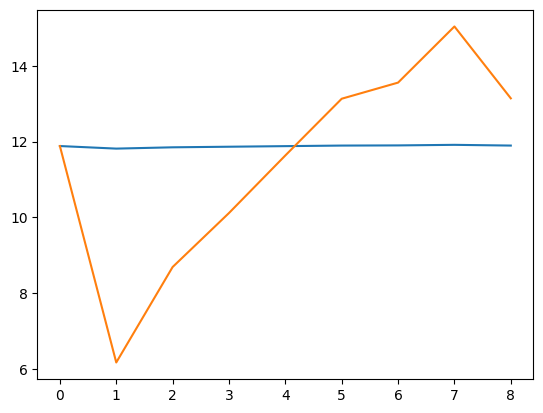

In [24]:
from scipy.optimize import minimize
def simulate_course_time(power, course_segments, critical_power, w_prime):
    """
    Simulate course time and W' usage for a given constant power.
    
    :param power: Constant power (W).
    :param course_segments: DataFrame containing course segment data (gradient, wind, length, etc.).
    :param critical_power: Critical power of the rider (W).
    :param w_prime: Anaerobic capacity (J).
    :return: DataFrame with segment speeds and other details.
    """
    total_time = 0
    w_remaining = w_prime
    total_energy_used = 0

    results = []

    for _, segment in course_segments.iterrows():
        gradient = segment['gradient']
        length = segment['distance']
        wind = segment['wind']
        altitude = segment['altitude']

        # Calculate speed for the given power
        
        speed_calc = calculate_speed_and_plot(power, gradient=gradient, v_wind=wind, altitude=altitude)
        speed = speed_calc['speed_mps']
        time = length / speed
        total_time += time

        # Track energy usage
        if power > critical_power:
            w_used = (power - critical_power) * time
            w_remaining -= w_used
            if w_remaining < 0:
                return pd.DataFrame(results), float('inf'), w_remaining, total_energy_used  # Rider "blows up"
        else:
            w_recovery = (critical_power - power) * time
            w_remaining = min(w_remaining + w_recovery, w_prime)

        total_energy_used += power * time

        # Store results for each segment
        results.append({
            'segment': segment.name,
            'gradient': gradient,
            'length': length,
            'wind': wind,
            'speed': speed,
            'time': time,
            'power': power,
            'w_remaining': w_remaining,
            'total_energy_used': total_energy_used
        })

    return pd.DataFrame(results), total_time, w_remaining, total_energy_used

def optimize_constant_power(course_segments, critical_power, w_prime):
    """
    Find the optimal constant power to use the rider's energy budget.
    
    :param course_segments: DataFrame containing course segment data.
    :param critical_power: Critical power of the rider (W).
    :param w_prime: Anaerobic capacity (J).
    :return: Optimal power and total time.
    """
    def objective(power):
        _, total_time, _, total_energy_used = simulate_course_time(power, course_segments, critical_power, w_prime)
        # Penalize if not using the full energy budget
        energy_penalty = abs((critical_power * total_time + w_prime) - total_energy_used)
        return total_time + energy_penalty   # Large penalty for unused energy

    bounds = [(critical_power-100, critical_power * critical_power*3)]  # Limit power near CP
    result = minimize(lambda p: objective(p[0]), x0=[critical_power], bounds=bounds, method='L-BFGS-B')

    optimal_power = result.x[0]
    df_speeds, optimal_time, _, _ = simulate_course_time(optimal_power, course_segments, critical_power, w_prime)
    return optimal_power, optimal_time, df_speeds


#raw segment shit: 
#course_segments=df[['distance','gradient','wind']].iloc[1:].rename(columns={'distance':'length'})

df_out, total_time, w_remaining, total_energy_used=simulate_course_time(352, course_segments, 350, 25000)
plt.plot(df_out['segment'], df_out['speed'])
print("Total time in minutes: ", f"{total_time/60:.0f}", " | Remaining W (J)': ",  f"{w_remaining/1000:.0f}", " | Total energy used (kj): ", f"{total_energy_used/1000:.0f}")


df_out, total_time, w_remaining, total_energy_used=simulate_course_time(352, df, 350, 25000)
plt.plot(df_out['segment'], df_out['speed'])
print("Total time in minutes: ", f"{total_time/60:.0f}", " | Remaining W (J)': ",  f"{w_remaining/1000:.0f}", " | Total energy used (kj): ", f"{total_energy_used/1000:.0f}")


Total time in minutes:  11  | Remaining W (J)':  18  | Total energy used (kj):  245


,segment,gradient,length,wind,speed,time,power,w_remaining,total_energy_used
0,0,0.000000,0.000000,0.0,11.979922,0.000000,360,25000.000000,0.000000
1,1,0.063135,189.181073,0.0,6.284112,30.104664,360,24698.953355,10837.679215
2,2,0.031205,722.281741,0.0,8.806962,82.012587,360,23878.827489,40362.210404
3,3,0.016745,1598.116100,0.0,10.225007,156.294860,360,22315.878884,96628.360176
4,4,0.002317,1878.252087,0.0,11.733559,160.075228,360,20715.126601,154255.442375
5,5,-0.011628,1510.468376,0.0,13.219082,114.264245,360,19572.484154,195390.570461
6,6,-0.015606,961.209797,0.0,13.641289,70.463267,360,18867.851482,220757.346652
7,7,-0.029666,768.606623,0.0,15.111859,50.861158,360,18359.239903,239067.363478
8,8,-0.011722,222.028555,0.0,13.229105,16.783339,360,18191.406514,245109.365482


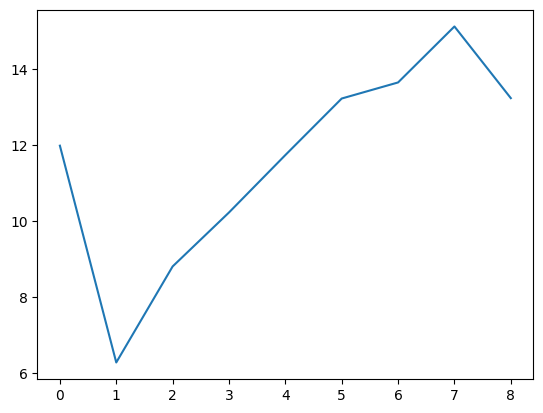

In [26]:
df_out, total_time, w_remaining, total_energy_used=simulate_course_time(360, df, 350, 25000)

print("Total time in minutes: ", f"{total_time/60:.0f}", " | Remaining W (J)': ",  f"{w_remaining/1000:.0f}", " | Total energy used (kj): ", f"{total_energy_used/1000:.0f}")
display(df_out)
plt.plot(df_out['segment'], df_out['speed'])


Total time in minutes:  18  | OPtimal Watts':  300


c:\Users\chrisuberti\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


,segment,gradient,length,wind,speed,time,power,w_remaining,total_energy_used
0,0,-0.011423,102.851832,0.794484,11.759727,8.746107,300.0,25000.0,2623.832057
1,1,-0.010585,114.500475,-0.007581,12.224035,9.366831,300.0,25000.0,5433.881399
2,2,0.053843,110.167528,1.240695,5.519616,19.959274,300.0,25000.0,11421.663649
3,3,-0.013644,120.233923,0.714571,12.060683,9.969080,300.0,25000.0,14412.387794
4,4,0.031541,113.091965,0.427858,7.447235,15.185766,300.0,25000.0,18968.117743
...,...,...,...,...,...,...,...,...,...
95,95,-0.037568,116.628765,1.815739,13.770509,8.469460,300.0,25000.0,324502.527485
96,96,-0.159407,102.730426,0.804846,-2.554219,-40.219900,300.0,25000.0,312436.557624
97,97,0.013775,118.958755,-1.401490,10.183919,11.681039,300.0,25000.0,315940.869449
98,98,0.011396,121.121622,-1.673071,10.631157,11.393080,300.0,25000.0,319358.793422


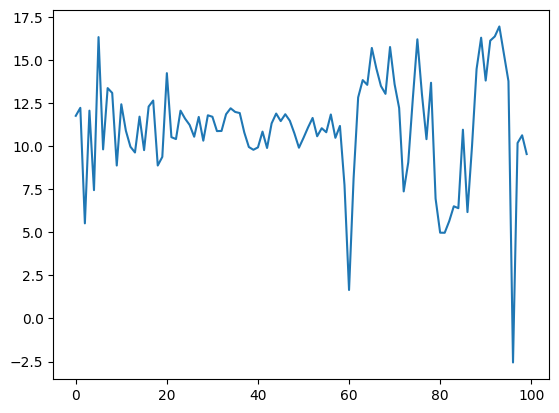

In [16]:
opt_power, opt_time, df_out = optimize_constant_power(course_segments, 300, 25000)

print("Total time in minutes: ", f"{opt_time/60:.0f}", " | OPtimal Watts': ",  f"{opt_power:.0f}")
display(df_out)
plt.plot(df_out['segment'], df_out['speed'])

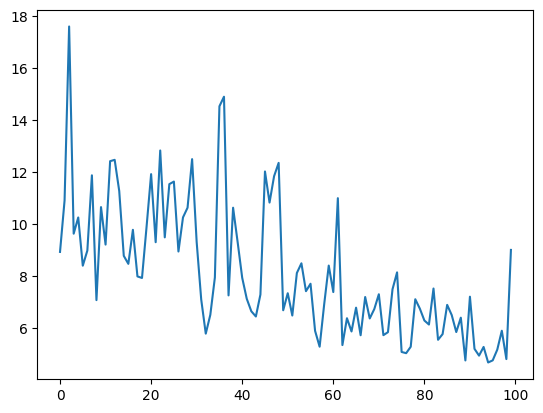

In [230]:
plt.plot(df_out['segment'], df_out['speed'])

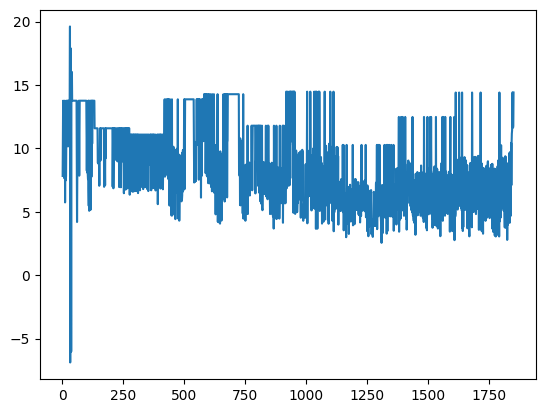

In [172]:
opt_power, time = optimize_constant_power(course_segments, 500, 25000)
print(f"Optimal power: {opt_power} W", f"Total time: {time/60/60} s")

1.812735722555644
1.8891714430163267
1.6804418032234412
1.5219381692889975
1.52343451440077
1.481233721176594
1.4592887258375706
1.4555287659295948
1.456816274510524
1.449989662137227
1.8127357225918261
1.889171443054151
1.6804418032570134
1.5219381693194545
1.523434514431236
1.4812337212062017
1.4592887258667195
1.45552876595869
1.4568162745396631
1.4499896621662038
2.1743958690967387
2.174395869060589
1.812735722555644
1.8891714430163267
1.6804418032234412
1.5219381692889975
1.52343451440077
1.481233721176594
1.4592887258375706
1.4555287659295948
1.456816274510524
1.449989662137227
1.8127357225918261
1.889171443054151
1.6804418032570134
1.5219381693194545
1.523434514431236
1.4812337212062017
1.4592887258667195
1.45552876595869
1.4568162745396631
1.4499896621662038
1.812735722555644
1.8891714430163267
1.6804418032234412
1.5219381692889975
1.52343451440077
1.481233721176594
1.4592887258375706
1.4555287659295948
1.456816274510524
1.449989662137227
Optimal power: 500.0 W Total time: 4.84

c:\Users\chrisuberti\Documents\GitHub\risk_analytics2\.conda\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [173]:
from scipy.optimize import minimize

def objective(power, course_segments, critical_power, w_prime):
    total_time = 0
    w_remaining = w_prime
    for i, segment in course_segments.iterrows():
        gradient = segment['gradient']
        length = segment['length']
        wind = segment['wind']
        speed = speed_from_power(power[i], gradient, wind)
        time = length / speed
        total_time += time
        
        # Deplete or recover W'
        if power[i] > critical_power:
            w_remaining -= (power[i] - critical_power) * time
        else:
            w_remaining = min(w_remaining + (critical_power - power[i]) * time, w_prime)
        
        if w_remaining < 0:  # Constraint violation
            total_time += 1e6  # Large penalty

    return total_time

def constraint(power):
    return sum(power) - max_allowed_energy

initial_power = [200] * len(course_segments)  # Initial guess
bounds = [(150, 400)] * len(course_segments)  # Power bounds per segment

result = minimize(objective, initial_power, args=(course_segments, 300, 15000), bounds=bounds)
optimal_power = result.x
